In [1]:
import allel
import loompy
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
import matplotlib.pyplot as plt
import math
import itertools
from collections import Counter
from collections import defaultdict

import mb_funcs as mb
%load_ext autoreload
%autoreload 2

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

In [2]:
mskcc_loomfile = '/n/fs/ragr-data/datasets/mskcc_iacobuzio/RA17_22/tapestri/RA17_22_39_13_liver_met/fresh/RA17_22_P2_IGO_11988_C_3.cells.loom'

with loompy.connect(mskcc_loomfile) as ds:
    print(ds.attrs.keys())
    print(ds.shape)

['CreationDate', 'LOOM_SPEC_VERSION', 'allsites_block', 'chemistry', 'coverage', 'genome_version', 'last_modified', 'mb_loom_version', 'n_reads', 'n_reads_per_cell', 'pipeline_version']
(46558, 2298)


In [3]:
ds = loompy.connect(mskcc_loomfile)

In [84]:
ds.close()

#### data overview

In [5]:
for key in ds.attrs.keys():
    print(f'{key}: {ds.attrs[key]}')

CreationDate: 20210610T064920.823079Z
LOOM_SPEC_VERSION: 2.0.1
allsites_block: 11133
chemistry: V2
coverage: 87
genome_version: hg19
last_modified: 20210610T064920.817797Z
mb_loom_version: 2.2
n_reads: 182403009
n_reads_per_cell: 16247
pipeline_version: 2.0.1


In [6]:
ds.layers.keys()

['', 'AD', 'DP', 'GQ', 'RO']

In [7]:
def generate_heatmap(data):
#     fig, ax = plt.subplots(1,1)
    g = sns.clustermap(data, row_cluster=False, col_cluster=False)
    g.ax_heatmap.set_ylabel('SNVs', fontsize=20)
    g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### What is the number of cells, positions, amplicons?

In [8]:
print(f"number of covered positions is {ds.shape[0]}")
print(f"number of cells is {ds.shape[1]}")
print(f"number of amplicons is {len(np.unique(ds.ra['amplicon']))}")
print(f"number of chromosomes is {len(np.unique(ds.ra['CHROM']))}")

number of covered positions is 46558
number of cells is 2298
number of amplicons is 186
number of chromosomes is 22


#### Q: what is nonref_cells in row attributes?

In [9]:
ds.ra.keys()

['ALT',
 'CHROM',
 'CLNDEF',
 'COMMON',
 'POS',
 'QUAL',
 'REF',
 'RSID',
 'amplicon',
 'id',
 'nonref_cells']

In [10]:
pd.Series(ds.ra['nonref_cells']).value_counts()

1       9689
2       7619
0       7433
3       5508
4       4161
        ... 
46         1
78         1
174        1
206        1
1983       1
Length: 244, dtype: int64

#### position dataframe

In [11]:
df_pos = pd.DataFrame({'pos': list(ds.ra['POS']),
                       'chrom': list(ds.ra['CHROM']),
                       'amplicon': list(ds.ra['amplicon']),
                       'ref': list(ds.ra['REF']),
                       'alt': list(ds.ra['ALT'])})

df_pos['ref_len'] = df_pos['ref'].apply(len)
df_pos['alt_len'] = df_pos['alt'].apply(len)
df_pos['normal'] = (df_pos['ref_len'] == 1) & (df_pos['alt_len'] == 1)

df_pos['index'] = df_pos.index

In [12]:
df_pos

,pos,chrom,amplicon,ref,alt,ref_len,alt_len,normal,index
0,27057731,1,AMPL50980,A,T,1,1,True,0
1,27057731,1,AMPL50980,A,G,1,1,True,1
2,27057736,1,AMPL50980,C,A,1,1,True,2
3,27057746,1,AMPL50980,A,ATTACAACATC,1,11,False,3
4,27057746,1,AMPL50980,A,G,1,1,True,4
...,...,...,...,...,...,...,...,...,...
46553,76777892,X,AMPL70504,T,C,1,1,True,46553
46554,76777893,X,AMPL70504,T,C,1,1,True,46554
46555,76777893,X,AMPL70504,T,A,1,1,True,46555
46556,76777894,X,AMPL70504,C,T,1,1,True,46556


In [13]:
df_pos[df_pos['pos'] == 27057726]

,pos,chrom,amplicon,ref,alt,ref_len,alt_len,normal,index
11330,27057726,1,AMPL50980,T,A,1,1,True,11330


(array([2.157e+03, 0.000e+00, 1.220e+02, 0.000e+00, 1.400e+01, 0.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

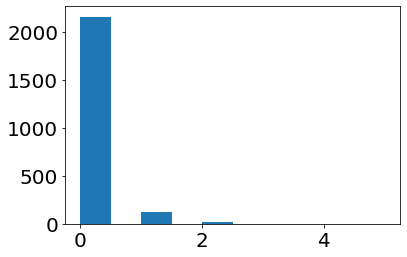

In [14]:
plt.hist(ds.layers['AD'][4,:])

(array([2.134e+03, 0.000e+00, 1.230e+02, 0.000e+00, 3.200e+01, 0.000e+00,
        8.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

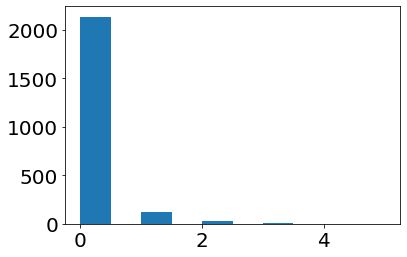

In [15]:
plt.hist(ds.layers['AD'][3,:])

(array([25852.,     0.,     0.,     0.,     0., 10281.,     0.,     0.,
            0.,    48.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

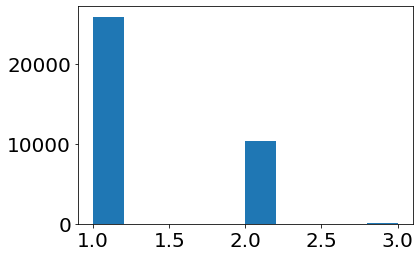

In [16]:
plt.hist(df_pos.groupby(['pos', 'amplicon'])['index'].count().values)

In [17]:
df_unique_pos = df_pos.groupby(['pos', 'amplicon']).last().reset_index()

In [18]:
len(df_unique_pos)

36181

In [19]:
df_unique_pos

,pos,amplicon,chrom,ref,alt,ref_len,alt_len,normal,index
0,346979,AMPL87363,16,T,C,1,1,True,34618
1,346980,AMPL87363,16,G,T,1,1,True,34620
2,346981,AMPL87363,16,C,,1,0,False,34621
3,346982,AMPL87363,16,A,T,1,1,True,7373
4,346983,AMPL87363,16,C,T,1,1,True,7374
...,...,...,...,...,...,...,...,...,...
36176,198266798,AMPL87266,2,A,G,1,1,True,16181
36177,198266799,AMPL87266,2,GGCA,,4,0,False,16182
36178,198266800,AMPL87266,2,G,A,1,1,True,16183
36179,198266801,AMPL87266,2,C,A,1,1,True,1639


#### What is the actual number of positions?

In [20]:
print(f"Total number of positions is {len(df_unique_pos)}")

Total number of positions is 36181


#### What is the number of positions covered in each chromosome?

In [21]:
df_unique_pos['chrom'].value_counts()

17    4305
12    2960
2     2690
3     2689
7     2634
1     2483
X     2363
11    2163
19    1773
18    1472
5     1433
10    1337
6     1286
16    1188
4     1028
9      923
20     863
15     829
8      809
13     588
22     208
14     157
Name: chrom, dtype: int64

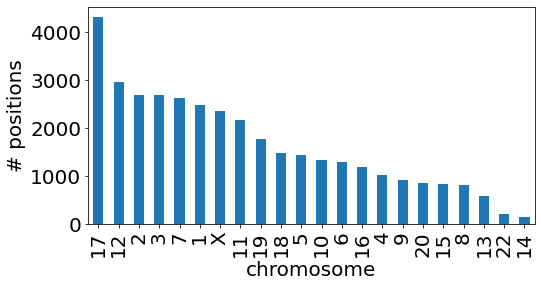

In [22]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_unique_pos['chrom'].value_counts().plot.bar()
plt.gca().set_xlabel('chromosome');
plt.gca().set_ylabel('# positions');

#### what is the number of amplicons in each chromosome?

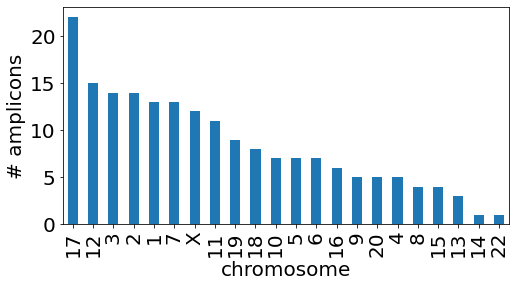

In [23]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_unique_pos.groupby('amplicon').first()['chrom'].value_counts().plot.bar()
plt.gca().set_xlabel('chromosome');
plt.gca().set_ylabel('# amplicons');

#### what is the number of positions in each amplicon

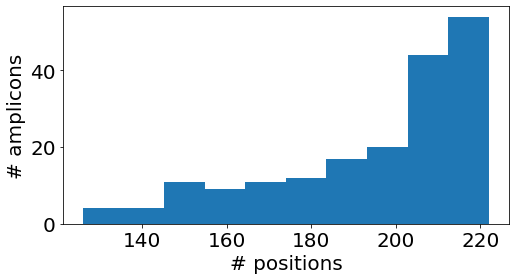

In [24]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_unique_pos['amplicon'].value_counts().plot.hist()
plt.gca().set_ylabel('# amplicons');
plt.gca().set_xlabel('# positions');

#### what is the coverage across cells?

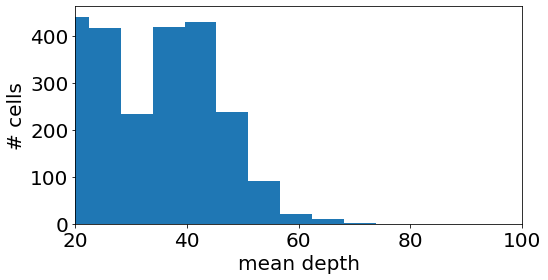

In [25]:
(mean_coverage, ) = ds.layers['DP'].map([np.mean], axis=1)
fig, ax = plt.subplots(1,1,figsize=(8,4))
plt.hist(mean_coverage);
plt.gca().set_xlabel('mean depth');
plt.gca().set_ylabel('# cells');
plt.gca().set_xlim((20, 100));

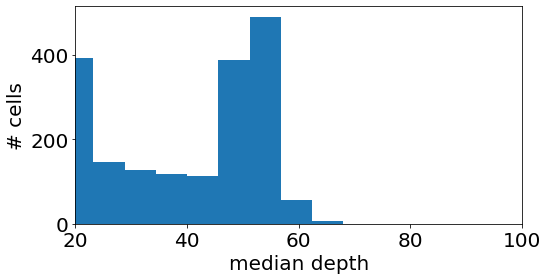

In [26]:
(median_coverage, ) = ds.layers['DP'].map([np.median], axis=1)
fig, ax = plt.subplots(1,1,figsize=(8,4))
plt.hist(median_coverage);
plt.gca().set_xlabel('median depth');
plt.gca().set_ylabel('# cells');
plt.gca().set_xlim((20, 100));

#### how much does read depth vary within each amplicon?

For each cell $i$ we look at the max read depth $M_{ij}$ and the min read depth $m_{ij}$ across all positions in amplicon $j$. <br>
Then we compute $m_{ij}/M_{ij}$. This is the most extreme factor by which the copy number estimate will vary for positions within amplicon $j$ in cell $i$.

We expect this number to be close to 1 because the read lengths should be comparable with the amplicon lengths. <br>

In [27]:
amplicon_list = list(df_unique_pos['amplicon'].unique())

namplicons = len(amplicon_list)

df_unique_pos = df_unique_pos.sort_values('index')

In [28]:
trim_perc = 0
empty_cells_median = np.zeros((namplicons, 1))

for idx, amplicon in enumerate(amplicon_list):
    selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values
    npos = len(selected_indices)
    if trim_perc > 0:
        cutoff = int(npos // (100 / trim_perc))
    else:
        cutoff = 0
    
    a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]

    median_depths = np.median(a, axis = 0)
    empty_cells_median[idx] = sum(median_depths == 0)

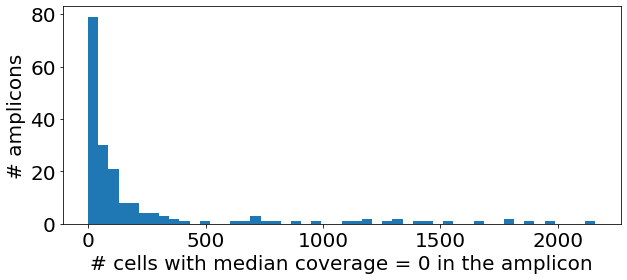

In [29]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
plt.hist(empty_cells_median, bins = 50)
plt.gca().set_ylabel('# amplicons', fontsize=20)
plt.gca().set_xlabel('# cells with median coverage = 0 in the amplicon', );

In [30]:
mb_analyzer = mb.analyzer(ds)

rejected 131 cells for amplicon AMPL87363
rejected 698 cells for amplicon AMPL87294
rejected 768 cells for amplicon AMPL87377
rejected 52 cells for amplicon AMPL87244
rejected 31 cells for amplicon AMPL87358


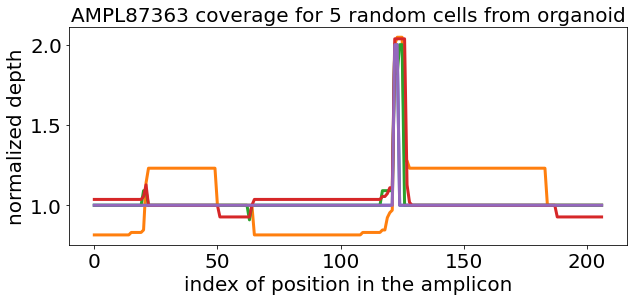

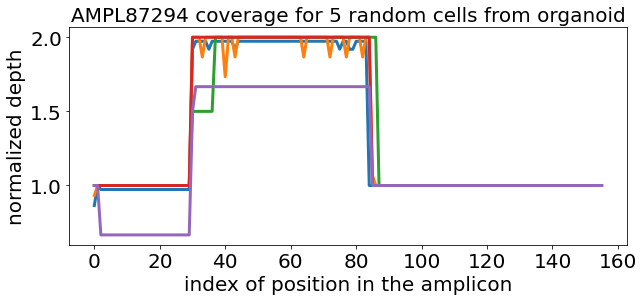

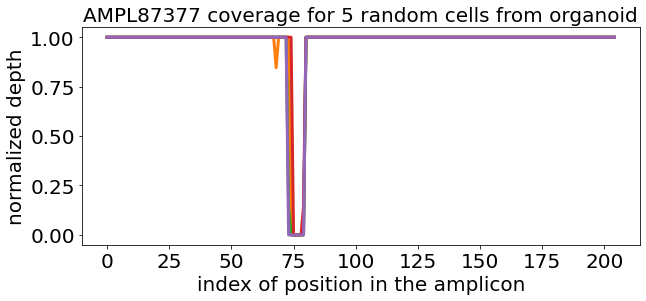

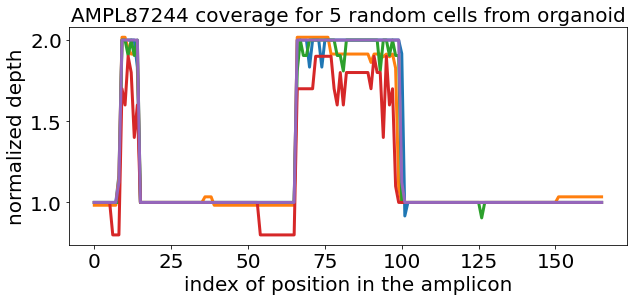

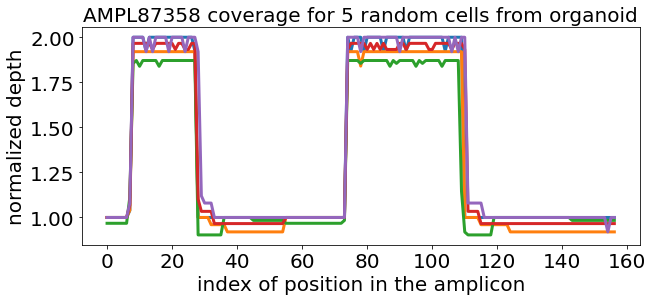

In [31]:
mb_analyzer.plot_amplicon_coverage(amplicon_list[0])
mb_analyzer.plot_amplicon_coverage(amplicon_list[4])
mb_analyzer.plot_amplicon_coverage(amplicon_list[20])
mb_analyzer.plot_amplicon_coverage(amplicon_list[43])
mb_analyzer.plot_amplicon_coverage(amplicon_list[140])

rejected 131 cells for amplicon AMPL87363
rejected 698 cells for amplicon AMPL87294
rejected 768 cells for amplicon AMPL87377
rejected 52 cells for amplicon AMPL87244
rejected 31 cells for amplicon AMPL87358


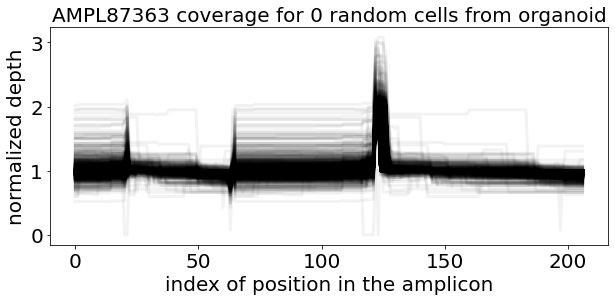

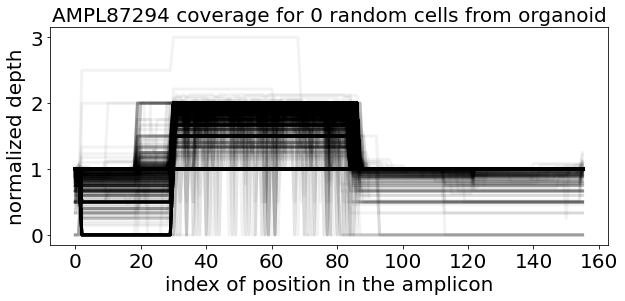

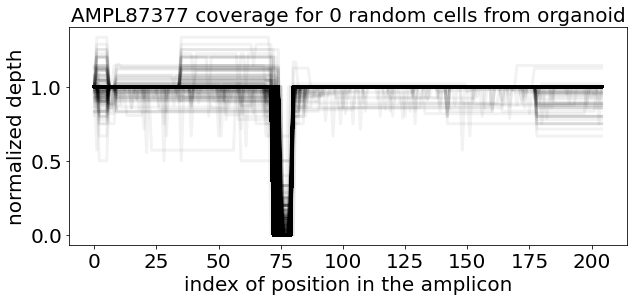

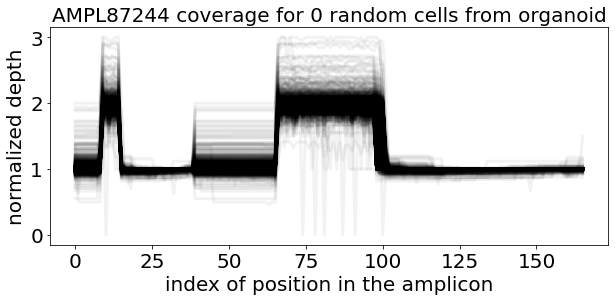

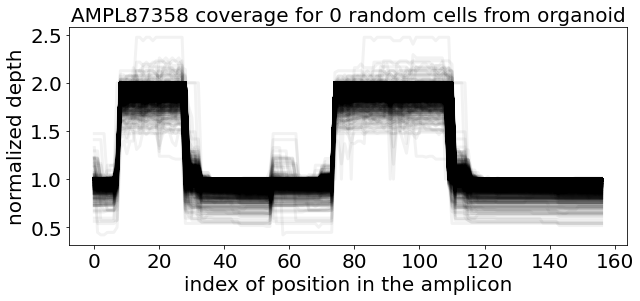

In [32]:
mb_analyzer.plot_amplicon_coverage(amplicon_list[0], nprobe = 0)
mb_analyzer.plot_amplicon_coverage(amplicon_list[4], nprobe = 0)
mb_analyzer.plot_amplicon_coverage(amplicon_list[20], nprobe = 0)
mb_analyzer.plot_amplicon_coverage(amplicon_list[43], nprobe = 0)
mb_analyzer.plot_amplicon_coverage(amplicon_list[140], nprobe = 0)

In [33]:
def plot_cell_coverage(cell_idx, nprobe = None, norm_flag = True, trim_perc = 0):

    depth_values = []
    pos_values = []
    prev_npos = 0
    breakpoint_locs = []
    namplicon = len(amplicon_list)
    if nprobe:
        np.random.seed(cell_idx)
        selected_amplicon_list = [amplicon_list[x] for x in np.random.randint(namplicon, size=nprobe)]
    else:
        selected_amplicon_list = amplicon_list.copy()
        
    for amplicon in selected_amplicon_list:
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], cell_idx]    


        if norm_flag:
            median_depth =  np.median(a)
            if median_depth == 0:
                a = np.zeros(a.shape)
            else:
                a = a / np.median(a)

        depth_values += list(a)
        pos_values += list(prev_npos + np.arange(npos))
        prev_npos += npos
        breakpoint_locs.append(prev_npos)
        
    fig, ax = plt.subplots(1,1,figsize=(40,4))
    plt.plot(pos_values, depth_values, linewidth=3)
    for idx in range(len(selected_amplicon_list)):
        plt.axvline(breakpoint_locs[idx], color='r')

    plt.gca().set_ylabel('read depth')
    plt.gca().set_xlabel('position index')  
    plt.xlim((0, prev_npos))
    
    if not nprobe:
        plt.title(f"coverage for all amplicons {'with' if norm_flag else 'without'} normalization", fontsize=20)
    else:
        plt.title(f"coverage for {nprobe} random amplicons {'with' if norm_flag else 'without'} normalization", fontsize=20)

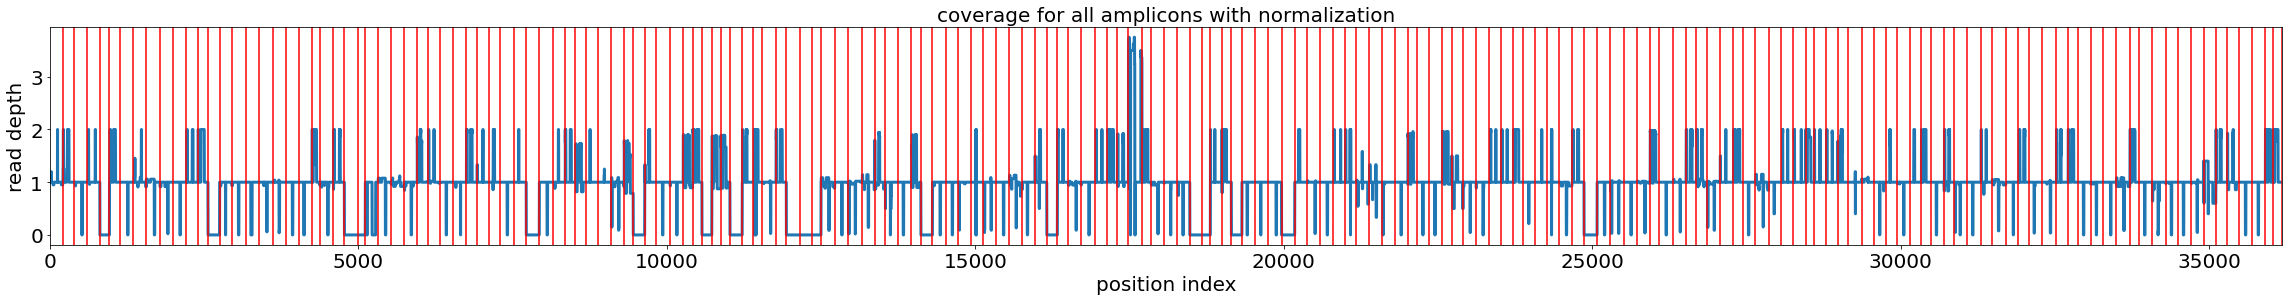

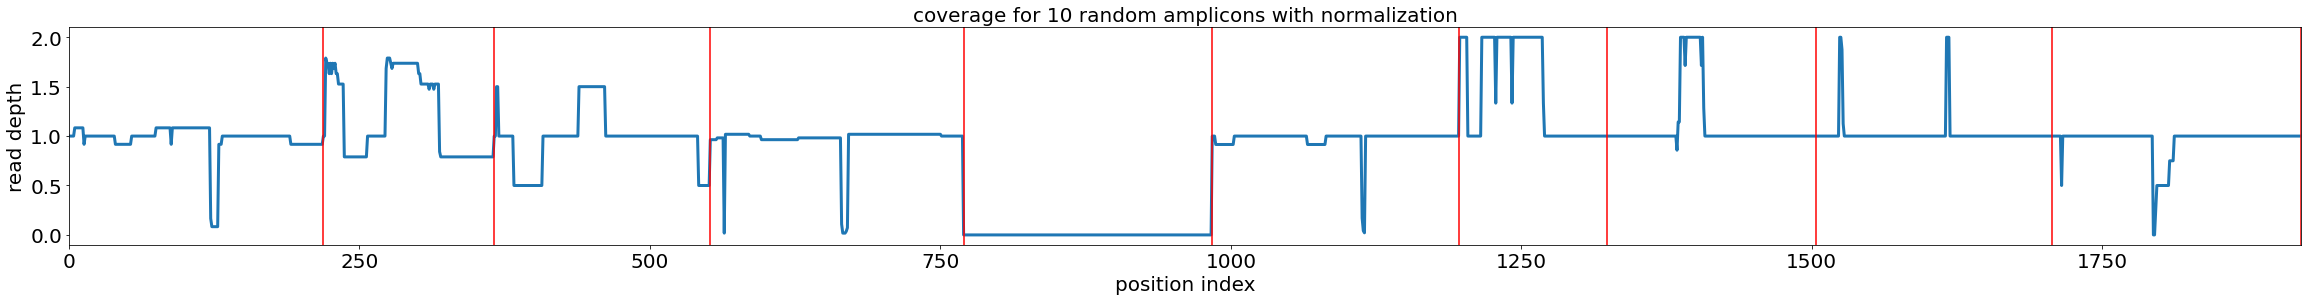

In [34]:
plot_cell_coverage(0)
plot_cell_coverage(0, nprobe = 10)

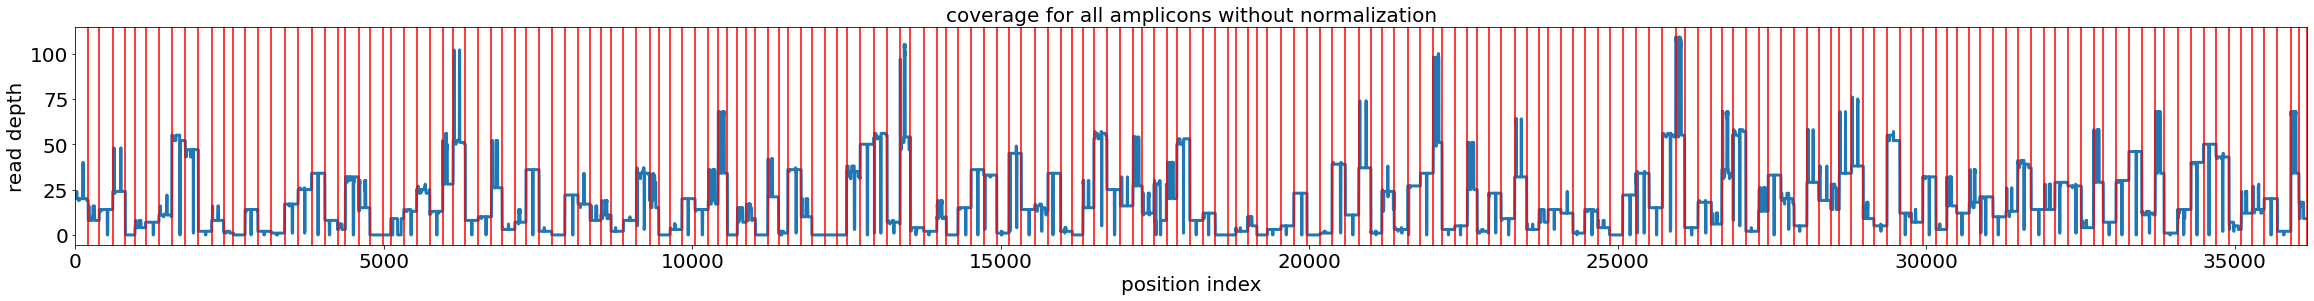

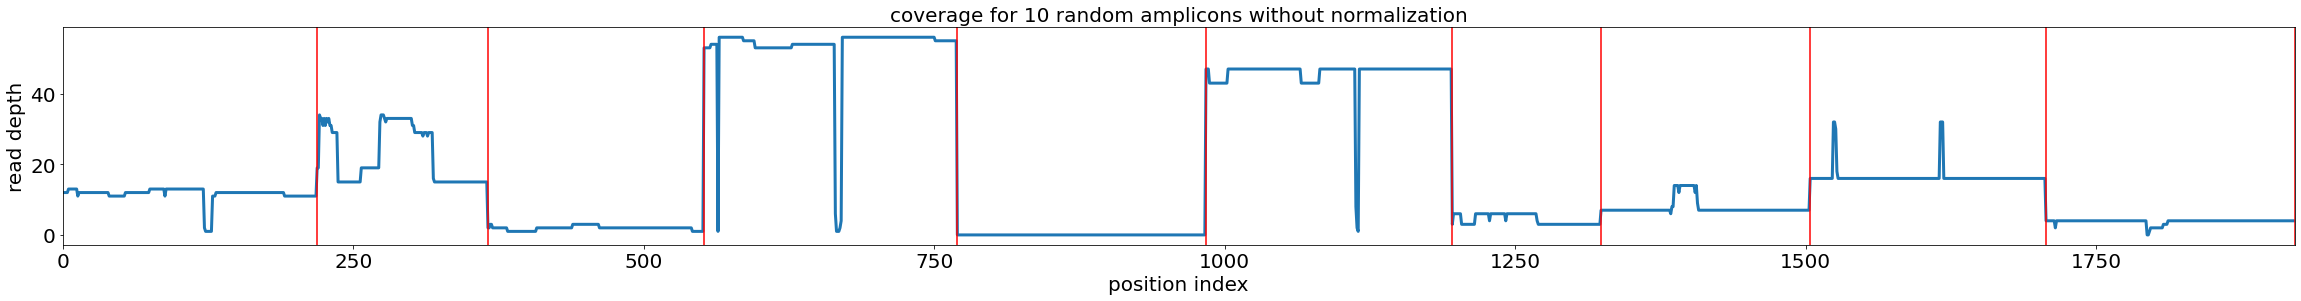

In [35]:
plot_cell_coverage(0, norm_flag=False)
plot_cell_coverage(0, nprobe = 10, norm_flag=False)

In [36]:
probe_quantile=[0.1, 0.25, 0.4, 0.6, 0.75, 0.9]

In [37]:
def plot_quantile_distribution(probe_quantile=[0.1, 0.25, 0.4, 0.6, 0.75, 0.9], trim_perc = 0, read_depth_threshold = 0):

    qrecord = None
    for amplicon in amplicon_list:
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    

        median_depths = np.median(a, axis = 0)
        a_filtered = a[:, median_depths > read_depth_threshold]
        a_filtered_normalized = a_filtered / np.median(a_filtered, axis = 0)

        if qrecord is not None:
            qrecord = np.hstack((qrecord, np.quantile(a_filtered_normalized, probe_quantile, axis = 0)))
        else:
            qrecord = np.quantile(a_filtered_normalized, probe_quantile, axis = 0)
        
    return qrecord
#     for idx in len(probe_quantile):
#         fig, ax = plt.subplots(1,1,figsize=(6,4))
#         plt.hist(qrecord[idx,:], bins = 20)
#         plt.gca().set_ylabel(f"({probe_quantile[idx]}th quantile)/median")
#         plt.gca().set_xlabel(f"# amplicons across cells")

In [38]:
qrecord = plot_quantile_distribution()

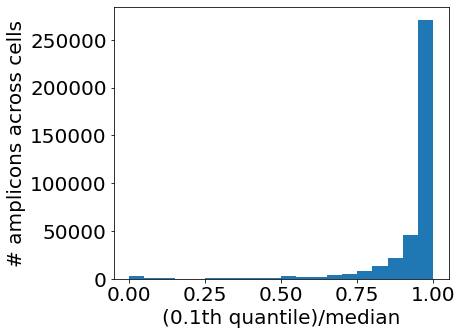

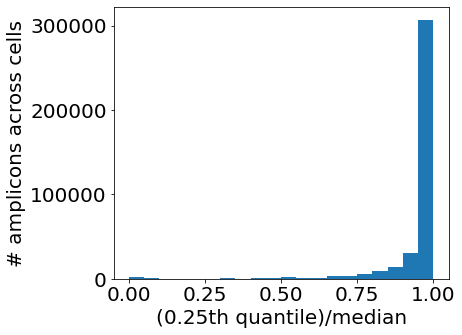

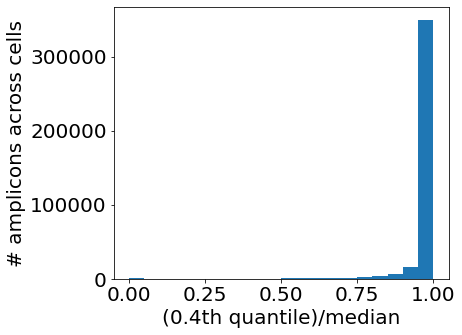

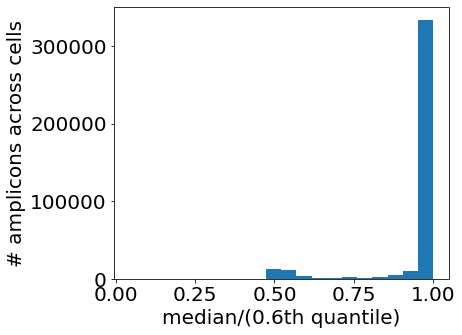

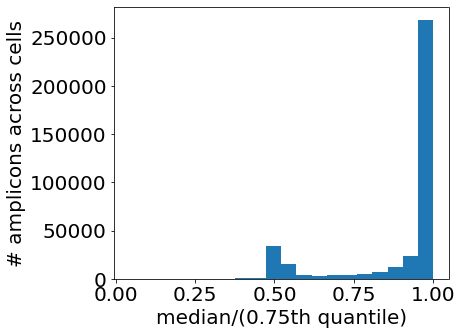

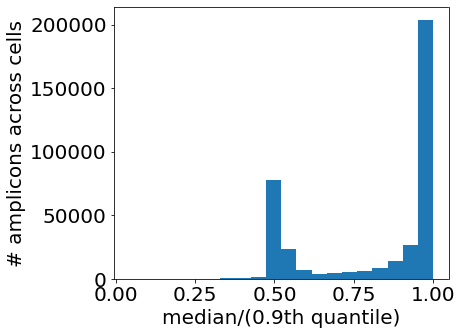

In [39]:
for idx in range(len(probe_quantile)):
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    if probe_quantile[idx] > 0.5:
        plt.hist(np.reciprocal(qrecord[idx,:]), bins = 20)
        plt.gca().set_xlabel(f"median/({probe_quantile[idx]}th quantile)")
    else:
        plt.hist(qrecord[idx,:], bins = 20)
        plt.gca().set_xlabel(f"({probe_quantile[idx]}th quantile)/median")
    plt.gca().set_ylabel(f"# amplicons across cells")
#     if probe_quantile[idx] > 0.5:
#         plt.xlim((1,15))

In [40]:
def get_read_depth_heatmap(amplicon_threshold = 0, trim_perc = 0, read_depth_threshold = 0):
    
    namplicon = len(amplicon_list)
    read_depth = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    

        if read_depth is not None:
            read_depth = np.vstack((read_depth, np.median(a, axis = 0)))
        else:
            read_depth = np.median(a, axis = 0)
    
    # selecting the cells in which the read depth is more than read depth threshold for at least amplicon threshold percent of the amplicons
    read_depth = read_depth[:, np.sum(read_depth >= read_depth_threshold, axis = 0) >= amplicon_threshold*namplicon]

    return read_depth

In [41]:
read_depth = get_read_depth_heatmap(amplicon_threshold=0, read_depth_threshold = 0)

In [42]:
# np.median(normalized_read_depth, axis = 1).shape

In [43]:
read_depth.shape

(186, 2298)

In [44]:
np.sum(read_depth, axis = 0).shape

(2298,)

In [45]:
# normalize the read depth of each cell by the total reads of that cell
normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]

Text(0.5, 28.0, 'cells')

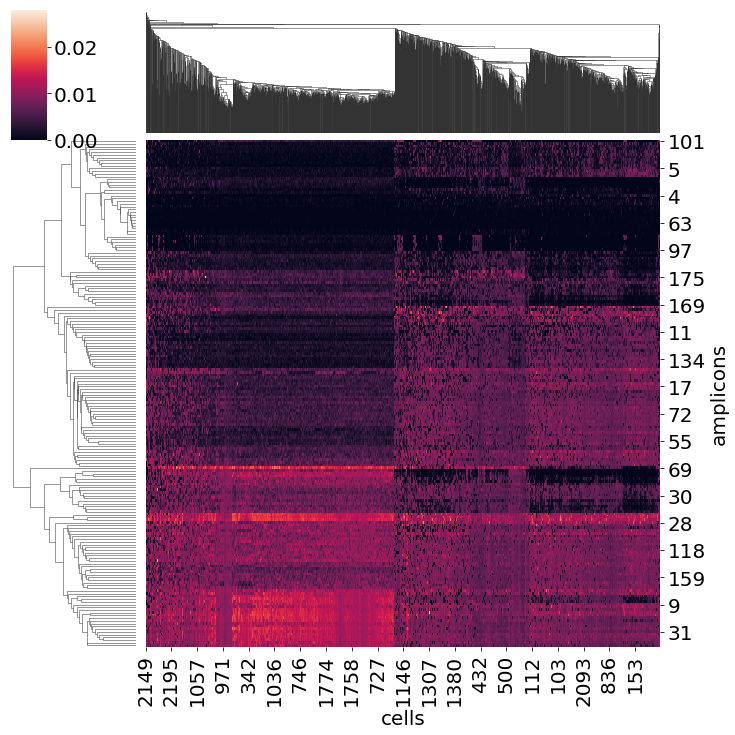

In [46]:
g = sns.clustermap(normalized_read_depth, row_cluster=True, col_cluster=True)
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [47]:
# remove amplicons with meidan read depth = 0 across all cells
relative_normalized_read_depth = normalized_read_depth[np.median(normalized_read_depth, axis = 1) > 0, :]
# further normalize the read depth in each amplicon by the median read depth of that amplicon across all cells
relative_normalized_read_depth = relative_normalized_read_depth / np.median(relative_normalized_read_depth, axis = 1)[:, None]

Text(0.5, 28.0, 'cells')

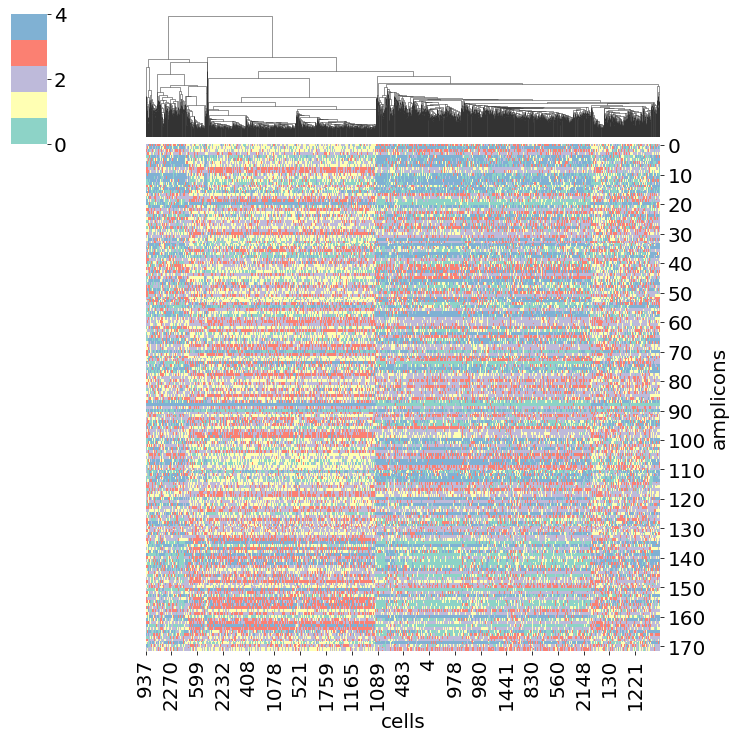

In [48]:
g = sns.clustermap(relative_normalized_read_depth*2, row_cluster=False, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [49]:
relative_normalized_read_depth.shape

(172, 2298)

**We filter the cells with low coverage this time**

In [50]:
read_depth = get_read_depth_heatmap(amplicon_threshold=0.8, read_depth_threshold = 10)

In [51]:
read_depth.shape

(186, 284)

In [52]:
# normalize the read depth of each cell by the total reads of that cell
normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]

Text(0.5, 40.75, 'cells')

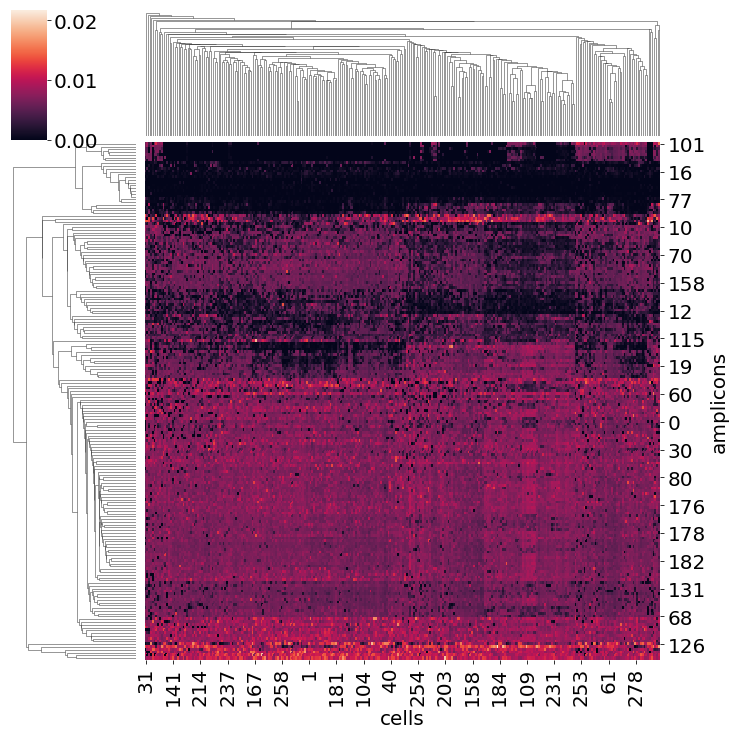

In [53]:
g = sns.clustermap(normalized_read_depth, row_cluster=True, col_cluster=True)
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [54]:
# remove amplicons with meidan read depth = 0 across all cells
relative_normalized_read_depth = normalized_read_depth[np.median(normalized_read_depth, axis = 1) > 0, :]
# further normalize the read depth in each amplicon by the median read depth of that amplicon across all cells
relative_normalized_read_depth = relative_normalized_read_depth / np.median(relative_normalized_read_depth, axis = 1)[:, None]

Text(0.5, 40.75, 'cells')

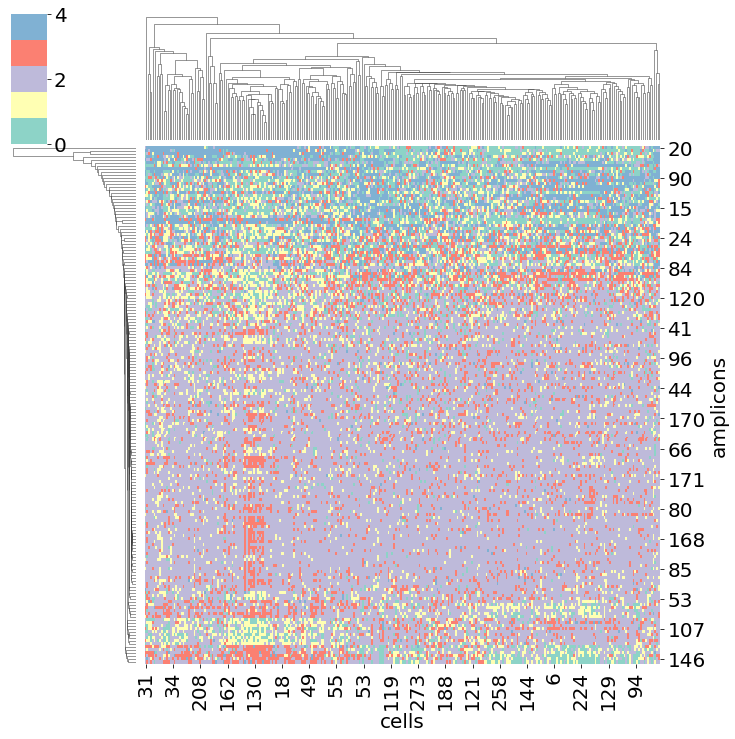

In [69]:
g = sns.clustermap(relative_normalized_read_depth*2, row_cluster=True, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### construct condensed VAF matrix

In [70]:
def get_condensed_vaf_matrix(read_depth_threshold = 10, vaf_threshold = 0.25, presence_threshold = 0.05, amplicon_threshold=0.8):
    
    namplicon = len(amplicon_list)
    vaf_mat = None
    read_depth_mat = None
    read_depth = None
    cum_pos_indices = None
    cum_cell_indices = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_pos[df_pos['amplicon'] == amplicon]['index'].values
        
        b = ds.layers['AD'][selected_indices, :]
        a = ds.layers['DP'][selected_indices, :]
        
        # build read depth mat
        if read_depth is not None:
            read_depth = np.vstack((read_depth, np.median(a, axis = 0)))
        else:
            read_depth = np.median(a, axis = 0)        
        
        # remove positions with median read depth less than read_depth_threshold
        selected_indices = selected_indices[np.median(a, axis = 1) >= read_depth_threshold][:,None]
        b = b[np.median(a, axis = 1) >= read_depth_threshold, :]
        a = a[np.median(a, axis = 1) >= read_depth_threshold, :]        

        if vaf_mat is not None:
            vaf_mat = np.vstack((vaf_mat, b / a))
            read_depth_mat = np.vstack((read_depth_mat, a))
        else:
            vaf_mat = b / a
            read_depth_mat = a
        
        if cum_pos_indices is not None:
            cum_pos_indices = np.vstack((cum_pos_indices, selected_indices))
        else:
            cum_pos_indices = selected_indices.copy()

    ncells = vaf_mat.shape[1]
    cum_cell_indices = np.arange(ncells)
    
    # selecting the cells in which the read depth is more than read depth threshold for at least amplicon threshold percent of the amplicons
    if amplicon_threshold > 0:
        curr_selected_indices = np.sum(read_depth >= read_depth_threshold, axis = 0) >= amplicon_threshold*namplicon
        vaf_mat = vaf_mat[:, curr_selected_indices]
        read_depth_mat = read_depth_mat[:, curr_selected_indices]
        cum_cell_indices = cum_cell_indices[curr_selected_indices]

    # remove positions with max vaf less than vaf_threshold
    curr_selected_indices = np.nanmax(vaf_mat, axis = 1) >= vaf_threshold
    cum_pos_indices = cum_pos_indices[curr_selected_indices]
    vaf_mat = vaf_mat[curr_selected_indices, :]
    read_depth_mat = read_depth_mat[curr_selected_indices, :]
    
    # remove positions with vaf less than vaf_threshold in less than presense_threshold fraction of the cells
    ncells = vaf_mat.shape[1]
    vaf_threshold_cell_count = (np.nan_to_num(vaf_mat) >= vaf_threshold).sum(axis = 1)
    curr_selected_indices = vaf_threshold_cell_count >= presence_threshold*ncells
    cum_pos_indices = cum_pos_indices[curr_selected_indices]
    vaf_mat = vaf_mat[curr_selected_indices, :]
    read_depth_mat = read_depth_mat[curr_selected_indices, :]
    
    return vaf_mat, read_depth_mat, cum_pos_indices.flatten(), cum_cell_indices

In [71]:
condensed_vaf_mat, read_depth_mat, pos_indices, cell_indices = get_condensed_vaf_matrix(amplicon_threshold = 0) 

<ipython-input-70-0433fcf0624d>:30: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = b / a
<ipython-input-70-0433fcf0624d>:27: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = np.vstack((vaf_mat, b / a))


In [72]:
condensed_vaf_mat.shape

(157, 2298)

Text(0.5, 28.0, 'cells')

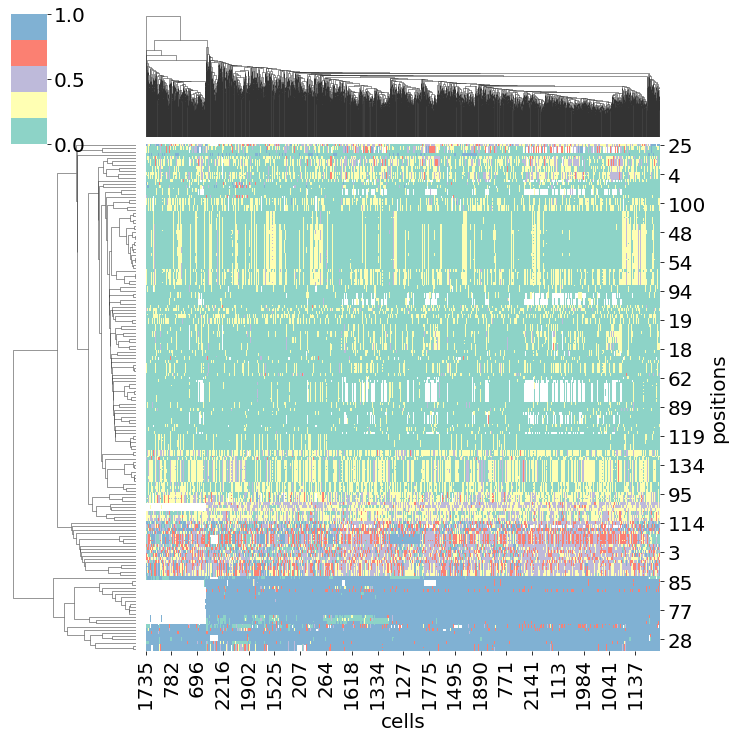

In [73]:
# masking entries with read dpeth less than 10
g = sns.clustermap(np.nan_to_num(condensed_vaf_mat), mask= read_depth_mat < 10, row_cluster=True, col_cluster=True, vmin=0, vmax=1,
                   cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [79]:
selected_vaf_mat, selected_read_depth_mat, selected_pos_indices, selected_cell_indices = get_condensed_vaf_matrix(amplicon_threshold = 0, presence_threshold = 0.2, vaf_threshold=0.33) 

<ipython-input-70-0433fcf0624d>:30: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = b / a
<ipython-input-70-0433fcf0624d>:27: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = np.vstack((vaf_mat, b / a))


In [80]:
selected_vaf_mat.shape

(65, 2298)

Text(0.5, 28.0, 'cells')

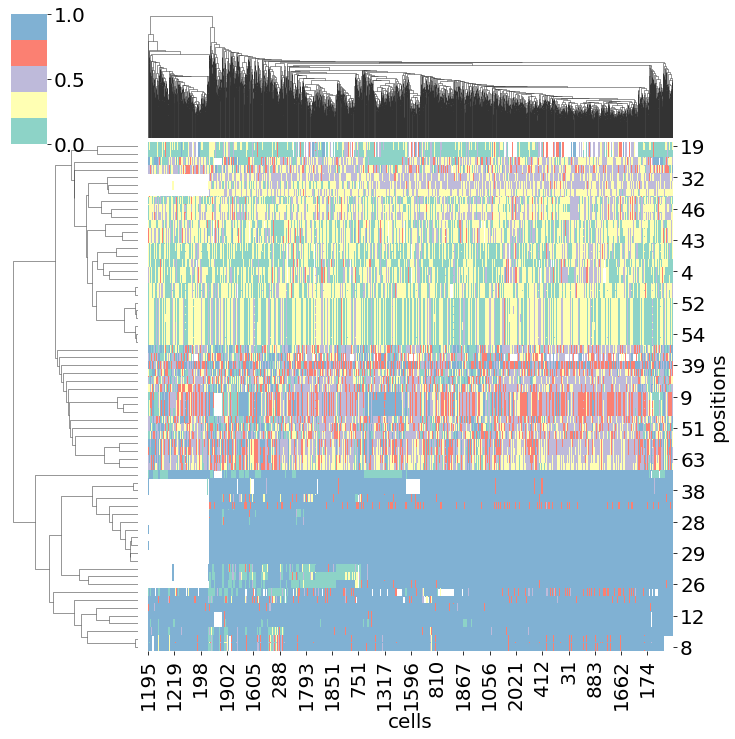

In [81]:
# masking entries with read dpeth less than 10
g = sns.clustermap(np.nan_to_num(selected_vaf_mat), mask= selected_read_depth_mat < 10, row_cluster=True, col_cluster=True, vmin=0, vmax=1,
                   cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [82]:
def write_snv_mat(dest_prefix, vaf_mat, read_depth_mat, pos_indices, cell_indices, mutation_presence_threshold=0.2, homozygous_mutation_threshold=0.8):
    snv_mat = np.zeros(vaf_mat.shape)
    snv_mat[vaf_mat < mutation_presence_threshold] = 0
    snv_mat[vaf_mat >= homozygous_mutation_threshold] = 2
    snv_mat[(vaf_mat >= mutation_presence_threshold) & (vaf_mat < homozygous_mutation_threshold)] = 1
    snv_mat[np.isnan(vaf_mat)] = 3
    snv_mat = snv_mat.astype(int)
    
    np.savetxt(f"{dest_prefix}_scite_snv_mat.txt", snv_mat, delimiter=" ", fmt='%d')
    df_pos.set_index('index').loc[pos_indices].reset_index().drop(['ref_len', 'alt_len', 'normal'], axis=1).to_csv(f'{dest_prefix}_pos_indices.csv', sep=',', index=False)
    
    snv_mat_str = snv_mat.astype(str)
    snv_mat_str = np.char.replace(snv_mat_str, '3', '?').T
    snv_mat_phiscs = np.vstack((np.hstack((np.array([['cell_idx/mut_idx']]), pos_indices[None, :].astype(str))), np.hstack((cell_indices[:,None], snv_mat_str))))
    np.savetxt(f"{dest_prefix}_phiscs_snv_mat.txt", snv_mat_phiscs, delimiter=" ", fmt='%s')
    
    return snv_mat

In [83]:
snv_mat = write_snv_mat('data/liver_met_selected', selected_vaf_mat, selected_read_depth_mat, selected_pos_indices, selected_cell_indices, mutation_presence_threshold=0.2, homozygous_mutation_threshold=0.8)